In [1]:
import os
import numpy as np
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
#sns.set(style="darkgrid")
from keras.models import load_model



Using TensorFlow backend.


In [2]:
df = pd.read_excel("time_series.xlsx")

In [3]:
df = df.iloc[:,1:2881]

In [4]:
df = df.dropna()

In [8]:
df = df.reset_index(drop=True)

In [9]:
display(df)

,0,1,2,3,4,5,6,7,8,9,...,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879
0,34.398087,34.398087,34.398087,34.398087,37.958370,37.958370,37.958370,37.958370,35.538284,35.538284,...,49.292221,49.292221,49.292221,43.439564,43.439564,43.439564,32.491669,32.491669,32.491669,32.491669
1,11.923971,11.923971,11.923971,11.923971,11.109582,11.109582,11.109582,11.109582,16.095539,16.095539,...,25.328291,25.328291,25.328291,30.823246,30.823246,30.823246,39.288010,39.288010,39.288010,39.288010
2,58.222057,58.222057,58.222057,58.222057,53.618980,53.618980,53.618980,53.618980,51.198895,51.198895,...,122.791733,122.791733,122.791733,125.047371,125.340759,125.340759,125.290382,125.290382,125.290382,125.290382
3,15.012849,15.012849,15.012849,15.012849,11.843982,11.843982,11.843982,11.843982,4.357113,4.357113,...,22.273878,22.273878,22.273878,22.045980,22.045980,22.045980,16.569902,16.569902,16.569902,16.569902
4,28.089104,28.089104,28.089104,28.089104,27.041897,27.041897,27.041897,27.041897,23.007502,23.007502,...,49.777802,49.777802,49.777802,51.152920,51.152920,51.152920,48.955788,48.955788,48.955788,48.955788
5,82.762115,82.762115,82.762115,82.762115,80.149406,80.149406,80.149406,80.149406,76.459694,76.459694,...,161.085953,161.085953,161.085953,189.291138,189.291138,189.291138,216.766022,216.766022,216.766022,216.766022
6,38.344837,38.344837,38.344837,38.344837,38.344837,0.038345,38.344837,38.344837,38.344837,38.344837,...,66.964516,66.964516,66.964516,64.905479,64.905479,64.905479,70.762062,70.762062,70.762062,70.762062
7,46.563629,46.563629,46.563629,46.563629,48.463173,48.463173,48.463173,48.463173,45.526272,45.526272,...,82.821243,82.821243,82.821243,91.866982,91.866982,91.866982,99.880157,99.880157,99.880157,99.880157
8,12.822731,12.822731,12.822731,12.822731,12.519598,12.519598,12.519598,12.519598,11.481169,11.481169,...,19.624456,19.624456,19.624456,17.622496,17.622496,17.622496,15.869956,15.869956,15.869956,15.869956
9,51.762833,51.762833,51.762833,51.762833,48.026012,48.026012,48.026012,48.026012,44.335934,44.335934,...,17.267157,17.267157,17.267157,16.872704,16.872704,16.872704,16.799774,16.799774,16.799774,16.799774


In [18]:
def isSubArray(A, B, n, m, st):
    ii = st
    j = 0
    while (ii < n and j < m): 
        if (A[ii] == B[j]): 
            ii += 1 
            j += 1 
            if (j == m): 
                return True 
        else: 
            ii = ii - j + 1 
            j = 0 
    return False 

In [11]:
l = []
for i in df.index:
    xx = df.iloc[i][:250].values
    #if any(np.equal(xx,[0,0,0,0]).all(1)):
    #vv = np.isin(xx,[0,0,0,0])
    #if [0.0,0.0,0.0,0.0] in xx.tolist():
    #print(xx)
    #array123 = lambda x: any([0,0,0,0] == x[offset:offset+3] for offset in range(len(x)))
    if(isSubArray(xx.tolist(),[0,0,0,0], 250, 4,0)):
        l.append(i)
    

In [14]:
l

[15,
 49,
 60,
 68,
 72,
 74,
 77,
 78,
 91,
 104,
 159,
 164,
 180,
 201,
 207,
 219,
 224,
 226,
 229,
 233,
 252,
 259,
 292,
 297,
 302,
 329,
 373,
 389,
 392,
 402,
 416,
 418,
 437,
 445,
 458,
 472,
 482,
 483,
 486,
 490,
 506]

In [13]:
df = df.drop(l)

In [15]:
df

,0,1,2,3,4,5,6,7,8,9,...,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879
0,34.398087,34.398087,34.398087,34.398087,37.958370,37.958370,37.958370,37.958370,35.538284,35.538284,...,49.292221,49.292221,49.292221,43.439564,43.439564,43.439564,32.491669,32.491669,32.491669,32.491669
1,11.923971,11.923971,11.923971,11.923971,11.109582,11.109582,11.109582,11.109582,16.095539,16.095539,...,25.328291,25.328291,25.328291,30.823246,30.823246,30.823246,39.288010,39.288010,39.288010,39.288010
2,58.222057,58.222057,58.222057,58.222057,53.618980,53.618980,53.618980,53.618980,51.198895,51.198895,...,122.791733,122.791733,122.791733,125.047371,125.340759,125.340759,125.290382,125.290382,125.290382,125.290382
3,15.012849,15.012849,15.012849,15.012849,11.843982,11.843982,11.843982,11.843982,4.357113,4.357113,...,22.273878,22.273878,22.273878,22.045980,22.045980,22.045980,16.569902,16.569902,16.569902,16.569902
4,28.089104,28.089104,28.089104,28.089104,27.041897,27.041897,27.041897,27.041897,23.007502,23.007502,...,49.777802,49.777802,49.777802,51.152920,51.152920,51.152920,48.955788,48.955788,48.955788,48.955788
5,82.762115,82.762115,82.762115,82.762115,80.149406,80.149406,80.149406,80.149406,76.459694,76.459694,...,161.085953,161.085953,161.085953,189.291138,189.291138,189.291138,216.766022,216.766022,216.766022,216.766022
6,38.344837,38.344837,38.344837,38.344837,38.344837,0.038345,38.344837,38.344837,38.344837,38.344837,...,66.964516,66.964516,66.964516,64.905479,64.905479,64.905479,70.762062,70.762062,70.762062,70.762062
7,46.563629,46.563629,46.563629,46.563629,48.463173,48.463173,48.463173,48.463173,45.526272,45.526272,...,82.821243,82.821243,82.821243,91.866982,91.866982,91.866982,99.880157,99.880157,99.880157,99.880157
8,12.822731,12.822731,12.822731,12.822731,12.519598,12.519598,12.519598,12.519598,11.481169,11.481169,...,19.624456,19.624456,19.624456,17.622496,17.622496,17.622496,15.869956,15.869956,15.869956,15.869956
9,51.762833,51.762833,51.762833,51.762833,48.026012,48.026012,48.026012,48.026012,44.335934,44.335934,...,17.267157,17.267157,17.267157,16.872704,16.872704,16.872704,16.799774,16.799774,16.799774,16.799774


In [16]:
df = df.reset_index(drop=True)

In [19]:
l = []
for i in df.index:
    xx = df.iloc[i][250:].values
    #if any(np.equal(xx,[0,0,0,0]).all(1)):
    #vv = np.isin(xx,[0,0,0,0])
    #if [0.0,0.0,0.0,0.0] in xx.tolist():
    #print(xx)
    #array123 = lambda x: any([0,0,0,0] == x[offset:offset+3] for offset in range(len(x)))
    if(isSubArray(xx.tolist(),[0,0,0,0], 250, 4,0)):
        l.append(i)
    

In [20]:
l

[9,
 13,
 25,
 41,
 42,
 75,
 80,
 90,
 94,
 105,
 108,
 120,
 125,
 133,
 159,
 194,
 195,
 197,
 201,
 210,
 219,
 230,
 234,
 249,
 261,
 263,
 273,
 284,
 286,
 290,
 315,
 318,
 349,
 369,
 385,
 390,
 397,
 402,
 426,
 438,
 464,
 470,
 471,
 476,
 477]

In [21]:
y = np.zeros(df.shape[0])

In [23]:
y[l]=1

In [24]:
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0.

In [64]:
xx = df.values
xx = xx[:,:250]
xx=xx.reshape(xx.shape[0],xx.shape[1],1)
#xx=xx.reshape(xx.shape[0],1,xx.shape[1])

In [65]:
# Spliting into traing and testing 
x_train, x_test, y_train, y_test = train_test_split(xx, y, test_size=0.33)

In [66]:
x_train.shape,x_test.shape

((320, 250, 1), (159, 250, 1))

In [101]:
model = Sequential()

In [102]:
model.add(LSTM(256,dropout = 0.2,recurrent_dropout=0.2,input_shape=(250,1)))

In [103]:
model.add(Dense(1, activation='sigmoid'))

In [104]:
model.compile(loss = 'binary_crossentropy' , optimizer='adam',metrics=['accuracy'])

In [ ]:
history = model.fit(x_train,y_train,epochs=200,validation_split=0.33,batch_size=400)

Train on 214 samples, validate on 106 samples
Epoch 1/200
214/214 [==============================] - 2s 9ms/step - loss: 0.7968 - acc: 0.2617 - val_loss: 0.6162 - val_acc: 0.8302
Epoch 2/200
214/214 [==============================] - 1s 2ms/step - loss: 0.6306 - acc: 0.7804 - val_loss: 0.4677 - val_acc: 0.9151
Epoch 3/200
214/214 [==============================] - 1s 2ms/step - loss: 0.5299 - acc: 0.8318 - val_loss: 0.3769 - val_acc: 0.9245
Epoch 4/200
214/214 [==============================] - 1s 2ms/step - loss: 0.4556 - acc: 0.8738 - val_loss: 0.3220 - val_acc: 0.9245
Epoch 5/200
214/214 [==============================] - 1s 2ms/step - loss: 0.4117 - acc: 0.8832 - val_loss: 0.2949 - val_acc: 0.9245
Epoch 6/200
214/214 [==============================] - 1s 2ms/step - loss: 0.4271 - acc: 0.8738 - val_loss: 0.2820 - val_acc: 0.9245
Epoch 7/200
214/214 [==============================] - 1s 2ms/step - loss: 0.3867 - acc: 0.8832 - val_loss: 0.2749 - val_acc: 0.9245
Epoch 8/200
214/214 [==

Epoch 62/200
214/214 [==============================] - 1s 2ms/step - loss: 0.2814 - acc: 0.9065 - val_loss: 0.2637 - val_acc: 0.9245
Epoch 63/200
214/214 [==============================] - 1s 2ms/step - loss: 0.2816 - acc: 0.9065 - val_loss: 0.2640 - val_acc: 0.9245
Epoch 64/200
214/214 [==============================] - 1s 2ms/step - loss: 0.2944 - acc: 0.9065 - val_loss: 0.2639 - val_acc: 0.9245
Epoch 65/200
214/214 [==============================] - 1s 3ms/step - loss: 0.3011 - acc: 0.9065 - val_loss: 0.2635 - val_acc: 0.9245
Epoch 66/200
214/214 [==============================] - 1s 2ms/step - loss: 0.2936 - acc: 0.9065 - val_loss: 0.2635 - val_acc: 0.9245
Epoch 67/200
214/214 [==============================] - 1s 2ms/step - loss: 0.3115 - acc: 0.9065 - val_loss: 0.2629 - val_acc: 0.9245
Epoch 68/200
214/214 [==============================] - 1s 3ms/step - loss: 0.2866 - acc: 0.9065 - val_loss: 0.2625 - val_acc: 0.9245
Epoch 69/200
214/214 [==============================] - 1s 2ms

Epoch 123/200
214/214 [==============================] - 0s 2ms/step - loss: 0.2728 - acc: 0.9065 - val_loss: 0.2723 - val_acc: 0.9245
Epoch 124/200
214/214 [==============================] - 0s 2ms/step - loss: 0.2858 - acc: 0.9065 - val_loss: 0.2734 - val_acc: 0.9245
Epoch 125/200
214/214 [==============================] - 0s 2ms/step - loss: 0.2894 - acc: 0.9065 - val_loss: 0.2738 - val_acc: 0.9245
Epoch 126/200
214/214 [==============================] - 1s 2ms/step - loss: 0.2857 - acc: 0.9065 - val_loss: 0.2712 - val_acc: 0.9245
Epoch 127/200
214/214 [==============================] - 1s 2ms/step - loss: 0.2879 - acc: 0.9065 - val_loss: 0.2704 - val_acc: 0.9245
Epoch 128/200
214/214 [==============================] - 1s 2ms/step - loss: 0.2808 - acc: 0.9065 - val_loss: 0.2697 - val_acc: 0.9245
Epoch 129/200
214/214 [==============================] - 0s 2ms/step - loss: 0.2869 - acc: 0.9065 - val_loss: 0.2687 - val_acc: 0.9245
Epoch 130/200
214/214 [==============================] 

Epoch 184/200
214/214 [==============================] - 1s 2ms/step - loss: 0.2767 - acc: 0.9065 - val_loss: 0.2833 - val_acc: 0.9151
Epoch 185/200
214/214 [==============================] - 0s 2ms/step - loss: 0.2853 - acc: 0.9065 - val_loss: 0.2780 - val_acc: 0.9151
Epoch 186/200
214/214 [==============================] - 1s 2ms/step - loss: 0.2642 - acc: 0.9065 - val_loss: 0.2773 - val_acc: 0.9151
Epoch 187/200
214/214 [==============================] - 0s 2ms/step - loss: 0.2645 - acc: 0.9112 - val_loss: 0.2774 - val_acc: 0.9245
Epoch 188/200
214/214 [==============================] - 0s 2ms/step - loss: 0.2656 - acc: 0.9112 - val_loss: 0.2757 - val_acc: 0.9245
Epoch 189/200
214/214 [==============================] - 1s 2ms/step - loss: 0.2826 - acc: 0.9112 - val_loss: 0.2722 - val_acc: 0.9245
Epoch 190/200
214/214 [==============================] - 1s 2ms/step - loss: 0.2570 - acc: 0.9159 - val_loss: 0.2688 - val_acc: 0.9245
Epoch 191/200
214/214 [==============================] 

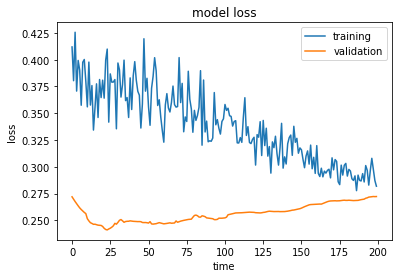

In [97]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('time')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()


In [98]:
pred = model.predict(x_test)
predict_classes = pred.argmax(axis = 1)
# Accuracy
print(sum(predict_classes==y_test)/len(y_test))

0.8930817610062893


In [99]:
cm = confusion_matrix(y_test,predict_classes)

Text(0.5, 15.0, 'Predicted label')

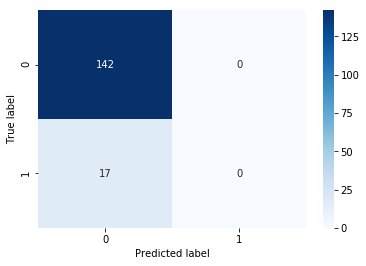

In [100]:
sns.heatmap(confusion_matrix(y_test,predict_classes),annot=True,fmt='d',cmap="Blues") 
plt.ylabel('True label')
plt.xlabel('Predicted label')